# Load the dataset

In [1]:
!pip install -U "datasets==3.6.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
### YOU MUST NOT CHANGE THIS CELL! ###

from datasets import load_dataset

full_dataset = load_dataset("skeskinen/TinyStories-GPT4", split="train")
full_dataset = full_dataset.remove_columns([c for c in full_dataset.column_names if c not in ["story", "features"]])
assert len(full_dataset) == 2745100

splits = full_dataset.train_test_split(test_size=10000, seed=42, shuffle=True)

train_dataset = splits["train"]
test_dataset  = splits["test"]

assert len(train_dataset) == 2735100
assert len(test_dataset)  == 10000

assert train_dataset[0]["story"][:33] == "One day, a little girl named Lily"
assert train_dataset[0]["features"] == ["Dialogue", "Conflict"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/554 [00:00<?, ?B/s]

(…)-00000-of-00008-c63ccd5d5290f4a1.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00001-of-00008-478199d8ac044910.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00002-of-00008-9b868f59be94d815.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00003-of-00008-d183cca02834cd90.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00004-of-00008-5f8ac0bb66de5834.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00005-of-00008-e8c22c3e776b87dd.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00006-of-00008-941f57106aca3340.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00007-of-00008-771d8aa2d5ce5c95.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2745100 [00:00<?, ? examples/s]

In [3]:
# Here we print the first example of the train dataset

from pprint import pprint
pprint(train_dataset[0])

{'features': ['Dialogue', 'Conflict'],
 'story': 'One day, a little girl named Lily went for a walk with her mom. '
          'They saw a big cliff near the water. Lily was fearful and did not '
          "want to go near the cliff. She held her mom's hand tight.\n"
          '"Mom, I am scared," Lily said. Her mom looked at her and smiled. '
          '"It\'s okay to be scared, but I will tell you a secret. When I am '
          'scared, I take a deep breath and count to three. Then, I feel '
          'better."\n'
          'Lily tried what her mom said. She took a deep breath and counted to '
          'three. She felt better and was not as scared. Then, a big bird flew '
          'by and almost hit Lily. She was scared again, but her mom was there '
          'to help her.\n'
          '"Remember what I told you, Lily. Take a deep breath and count to '
          'three," her mom said. Lily did it again, and she felt better. They '
          'walked away from the cliff, and Lily wa

In [34]:
!pip install gdown
import gdown
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
import pandas as pd
import string

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import BCEWithLogitsLoss
from torchsummary import summary
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [5]:
# Fix the seed for the reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Extract stories and labels from the test dataset
stories_test, labels_test = test_dataset['story'], test_dataset['features']

In [8]:
TAGS = ["BadEnding", "Conflict", "Dialogue", "Foreshadowing", "MoralValue", "Twist"]

#we define the f1_per_tag function where the inputs of the function are already binary vectors

def f1_per_tag(true_tag_lists, pred_tag_lists):

    scores = f1_score(true_tag_lists, pred_tag_lists, average=None, zero_division=0)
    return {t: float(s) for t, s in zip(TAGS, scores)}

Convert every label to a binary vector:

We define a mapping from each label to a unique index, then create a function to convert lists of labels into binary vectors. This allows us to represent the presence or absence of each label as 1s and 0s for model training.

In [9]:
label_to_index = {label: i for i, label in enumerate(TAGS)} # Map each label to a unique index (BadEnding->0, Conflict->1,...)

def list_to_binary(label_list):
    vector = [0] * len(TAGS) # Initialize a binary vector of zeros with length equal to number of labels
    for label in label_list:
        label = label.strip() # Remove any extra whitespace around the label
        vector[label_to_index[label]] = 1 # Set the position corresponding to this label to 1
    return vector

def binary_to_list(vector):
  return [TAGS[i] for i, value in enumerate(vector) if value == 1]

labels_bin_test = [list_to_binary(label) for label in labels_test]

# Model A: pretrained model RoBERTa

Load the best model for RoBERTa obtained from the training procedure and a pre-trained tokenizer for further fine-tuning or inference.

In [10]:
file_id_roberta = 'https://drive.google.com/file/d/1bavSp2TvsToWA7AIjMI4NQkOTUwqJcNj/view?usp=sharing'
file_name_roberta = 'best_model_RoBERTa.pt'
best_model_roberta = gdown.download(file_id_roberta, file_name_roberta, fuzzy=True, quiet=True)

In [11]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Create the DataLoader

In [12]:
test_encodings = tokenizer(stories_test, truncation=True, padding='max_length', max_length=256, return_tensors="pt")

# Converts in tensors
test_labels_tensor = torch.tensor(labels_bin_test, dtype=torch.float)

# Create the TensorDataset
test_dataset_A = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels_tensor)

# DataLoader
test_dataloader_A = DataLoader(test_dataset_A, batch_size=32, shuffle=False)

In [13]:
# Evaluate function
def evaluate_model(model, loader, loss_fn, thresholds=None):
    model.to(device)
    model.eval() # Evaluation mode

    if thresholds is None:
        thresholds = [0.5] * len(TAGS)

    #Initialization
    loss = 0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch[0].to(device)      #move input data to the device
            attention_mask = batch[1].to(device)
            labels = batch[2].float().to(device)

            output = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = output.logits                   #logits are suitable for our loss function
            loss += loss_fn(logits, labels).item()  #update the loss

            all_targets.append(labels.cpu().numpy())
            all_outputs.append(logits.cpu().numpy())



    # Avarage loss
    loss /= len(loader)

    # Calculate F1 score per tag
    all_targets = np.concatenate(all_targets, axis=0)
    all_outputs = np.concatenate(all_outputs, axis=0)

    # Apply sigmoid and threshold to get binary predictions
    pred_probabilities = torch.sigmoid(torch.tensor(all_outputs)).numpy()
    pred_tags = (pred_probabilities > thresholds).astype(int)

    # Calculate F1 scores per label
    f1_scores = f1_per_tag(all_targets, pred_tags)
    current_f1_values = np.array([f1_scores[tag] for tag in TAGS])

    print(f"Evaluation loss: {loss:.4f}")
    print("F1 Score per tag:")
    for tag, score in f1_scores.items():
        print(f"  {tag}: {score:.4f}")

    return loss, current_f1_values, pred_probabilities, pred_tags, all_targets

In [14]:
model_roberta = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=6,
    problem_type="multi_label_classification"
)

# Upload the weights
model_roberta.load_state_dict(torch.load(best_model_roberta, map_location=device))
model_roberta.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [15]:
loss_fn = BCEWithLogitsLoss()  # loss function suitable for RoBERTa

thresholds = [0.84, 0.39, 0.46, 0.20, 0.47, 0.42]   # best thresholds computed using the precision_recall_curve in the training procedure

_, _, pred_probabilities_A, pred_tags_A , true_tags_A = evaluate_model(model_roberta, test_dataloader_A, loss_fn, thresholds=thresholds)

Evaluation loss: 0.1283
F1 Score per tag:
  BadEnding: 0.9374
  Conflict: 0.5753
  Dialogue: 0.9397
  Foreshadowing: 0.5802
  MoralValue: 0.8769
  Twist: 0.9125


- Precision (Positive Predictive Value): measures how many of the predicted positive instances are actually correct
$$ Precision = \frac{TP}{TP +FP} $$

- Recall (Sensitivity, True Positive Rate): measures how many actual positive instances are correctly predicted:
$$ Recall = \frac{TP}{TP +FN} $$

- F1-Score: harmonic mean of precision and recall:
$$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

In [16]:
precision_A, recall_A, _, _ = precision_recall_fscore_support(true_tags_A, pred_tags_A, average=None, zero_division=0 )

# I create a DataFrame pandas to visualize all the results
results_df = pd.DataFrame({
    "Tag": TAGS,
    "Precision": precision_A,
    "Recall": recall_A,
})

print(results_df)

             Tag  Precision    Recall
0      BadEnding   0.966825  0.909699
1       Conflict   0.537951  0.618321
2       Dialogue   0.925998  0.953793
3  Foreshadowing   0.558252  0.603992
4     MoralValue   0.887786  0.866279
5          Twist   0.917857  0.907211


- Accuracy:
measures how often the model's predictions are correct:

$$ Accuracy = \frac{Number \ of \ correct \ predictions}{Total \  number \ of \ predictions} $$

In [17]:
# Compute the accuracy

correct_predictions_A = {}
for i, tag in enumerate(TAGS):
    true = true_tags_A[:, i]
    pred = pred_tags_A[:, i]
    acc = accuracy_score(true, pred) * 100
    correct_predictions_A[tag] = acc

print("Accuracy for each tag:")
for tag, accuracy in correct_predictions_A.items():
    print(f"- {tag}: {accuracy:.2f}%")

Accuracy for each tag:
- BadEnding: 98.91%
- Conflict: 91.63%
- Dialogue: 93.27%
- Foreshadowing: 91.68%
- MoralValue: 97.49%
- Twist: 96.55%


Confusion matrix shows how many examples were correctly or incorrectly classified into each class and it is very useful because it underlines what kinds of errors the model is making and if the model favors one class.

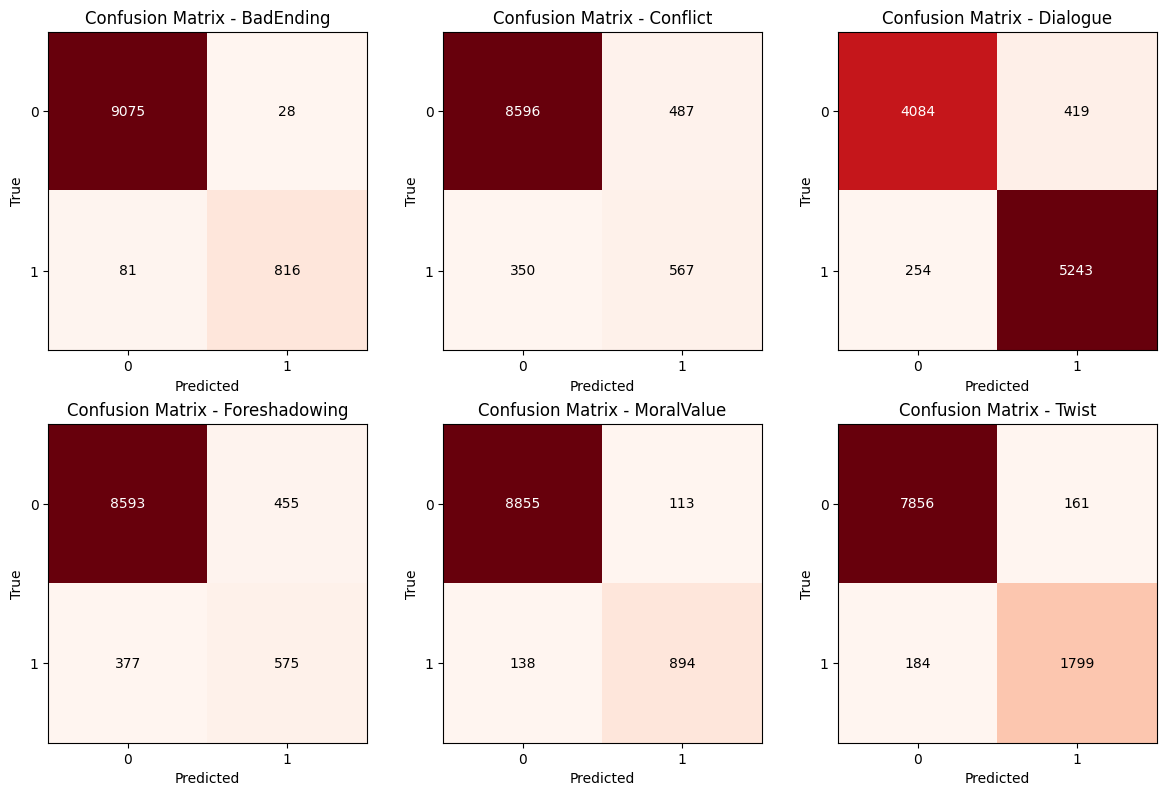

In [18]:
# Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 6 labels → 2 rows x 3 columns
axes = axes.flatten()

for i, tag in enumerate(TAGS):
    cm = confusion_matrix(true_tags_A[:, i], pred_tags_A[:, i])
    ax = axes[i]
    im = ax.imshow(cm, cmap='Reds')

    ax.set_title(f"Confusion Matrix - {tag}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    plt.savefig(f"model_A_cm_{tag}.png")

    for r in range(2):
        for c in range(2):
            ax.text(c, r, cm[r, c], ha="center", va="center", color="white" if cm[r, c] > 0.5 * cm.max() else "black")

plt.tight_layout()
plt.show()

# Model B: CNN model

We upload the small dataset that we created before in order to be consistent with the creation of the vocabulary for our CNN model.

In [19]:
url='https://drive.google.com/file/d/1lTZhwFsV55W_O9oBX6mSi3MLh-lXTmJF/view?usp=drive_link'    # Small dataset 400.000
file_name = 'small_dataset_400.000.csv'
gdown.download(url, file_name, fuzzy=True, quiet=False)
df = pd.read_csv("small_dataset_400.000.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1lTZhwFsV55W_O9oBX6mSi3MLh-lXTmJF
From (redirected): https://drive.google.com/uc?id=1lTZhwFsV55W_O9oBX6mSi3MLh-lXTmJF&confirm=t&uuid=517c60e8-2b29-44e0-a933-575a6c9ba4dc
To: /content/small_dataset_400.000.csv
100%|██████████| 334M/334M [00:05<00:00, 65.4MB/s]


In [20]:
# Convert stories and labels to a list
import ast

stories = df['stories'].tolist()
df_labels = df['labels'].apply(ast.literal_eval)
labels = df_labels.tolist()

In [21]:
labels_bin = [list_to_binary(label) for label in labels]

In [22]:
# Define a function that separate the words from the punctuation with an empty space
def simple_tokenizer(stories):

    punctuation = string.punctuation    # Construct a string for the punctuation
    all_tokens = []

    for text in stories:
        # Convert text to lowercase
        text = text.lower()

        # Iterate over each punctuation character
        for char in punctuation:
            # Add a space before and after that character in the text
            text = text.replace(char, f' {char} ')

        # Split the tokens when there is a space
        tokens = text.split()
        all_tokens.append(tokens)

    return all_tokens

In [23]:
# Apply the simple_tokenizer function to all the stories of the small_dataset:
stories_split = simple_tokenizer(stories)

Create the vocabulary

In [24]:
# Define a special token for padding and for unknown tokens
PAD_TOKEN = '[PAD]'
UNK_TOKEN = '[UNK]'

# Flatten the list of tokenized stories to get a single list of all tokens
all_tokens = [token for story in stories_split for token in story]

# Remove duplicates and sort the tokens
vocab_tokens = sorted(set(all_tokens))

V = [PAD_TOKEN, UNK_TOKEN] + vocab_tokens
token_to_index = {token: idx for idx, token in enumerate(V)}

vocab_size = len(V)

In [25]:
# Define a function to encode a story
def encode(x):
    return [token_to_index[token] if token in token_to_index else token_to_index[UNK_TOKEN] for token in x]

In [26]:
# How to choose max_length

lengths = [len(story) for story in stories_split]              # Compute the length of each story
max_length = int(np.percentile(lengths, 95))                    # Fix max_length s.t. 95% of the stories are shorter than max_length

print("Max length chosen:", max_length)

Max length chosen: 369


In [27]:
# Define a function to have all the stories of the same length
def truncate_and_pad(sequence):
    sequence = copy.copy(sequence)
    if len(sequence) > max_length:      # If the story is too long, take only the last max_length tokens => We give more weight to the end of the story rather than the beginning
        sequence = sequence[-max_length:]
    elif len(sequence) < max_length:    # If the story is too short add some PAD tokens (at the end of the story)
        sequence = sequence + [token_to_index[PAD_TOKEN]] * (max_length - len(sequence))

    return sequence

Create the DataLoader

In [28]:
# Preparation of small_test_dataset to evaluate the model:
test_stories_split = simple_tokenizer(stories_test)
test_stories_encoded = [encode(story) for story in test_stories_split]
test_stories_padded = [truncate_and_pad(story) for story in test_stories_encoded]

# Construct the TensorDataset
test_dataset_B = TensorDataset(torch.tensor(test_stories_padded, dtype = torch.long), torch.tensor(labels_bin_test, dtype = torch.float))

# Create DataLoader instances
batch_size = 32
test_dataloader_B = DataLoader(test_dataset_B, batch_size=batch_size, shuffle= False)

Define the evaluating procedure:

This function evaluates the best-performing model (previously saved during training) on the validation set.

In [29]:
# Evaluate function
def evaluate(model, loader, device):
    model.to(device)
    model.eval()    # Evaluation mode
    loss = 0

    loss_fn = nn.BCEWithLogitsLoss()
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)      # Access input_ids
            target = target.to(device)  # Access labels

            output = model(data)
            loss += loss_fn(output, target).item()     #Update the loss

            all_targets.append(target.cpu().numpy())
            all_outputs.append(output.cpu().numpy())


    loss /= len(loader)

    # Calculate F1 score per tag
    all_targets = np.concatenate(all_targets)
    all_outputs = np.concatenate(all_outputs)

    # Apply sigmoid and threshold to get binary predictions
    pred_probabilities = torch.sigmoid(torch.tensor(all_outputs)).numpy()
    pred_tags = (pred_probabilities > 0.5).astype(int)

    # Calculates F1 scores per label
    f1_scores = f1_per_tag(all_targets, pred_tags)
    current_f1_values = np.array([f1_scores[tag] for tag in TAGS]) # np.array with F1 values


    print(f'Evaluation loss: {loss:.4f}')
    print("F1 Score per tag:")
    for tag, score in f1_scores.items():
        print(f"  {tag}: {score:.4f}")

    return loss, current_f1_values, pred_probabilities, pred_tags, all_targets

Load the best model for CNN model obtained from the training procedure.

In [30]:
file_id_CNN = 'https://drive.google.com/file/d/1yanvtYTnJEqD4f7EMwanwWX2CmXlWjbB/view?usp=sharing' # Best model with 400.000 training dataset
file_name_CNN = 'best_model_CNN.pt'
best_model_CNN = gdown.download(file_id_CNN, file_name_CNN, fuzzy=True, quiet=True)

We defined a PyTorch class called Transpose that we will use inside our neural network in order to swap two dimensions of a tensor. Note that, in PyTorch, nn.Embedding() returns a b×l×d tensor (where b is the batch size, l is the sequence length, and d is the embedding dimension), whereas nn.Conv1d() espects a b×d×l tensor. Therefore, if you use these layers in your 1-dimensional CNN, you need to swap the second and third dimension between the embedding layer and the first convolutional layer.

In [31]:
class Transpose(nn.Module):
    """Swap two tensor dimensions inside a Sequential."""
    def __init__(self, dim0: int, dim1: int):
        super().__init__()
        self.dim0, self.dim1 = dim0, dim1

    def forward(self, x):
        # x is returned as a **view**, so this is zero‑copy
        return x.transpose(self.dim0, self.dim1)

We obtained the best hyperparameters through the Grid Search after the training procedure.

In [32]:
# Best hyperparameters:
best_lr = 0.0005
best_embedding_dim = 300
best_drop_out = 0.4
best_filters_conv1 = 128
best_kernel_size_conv1 = 3
best_filters_conv2 = 64
best_kernel_size_conv2 = 3

In [50]:
# Definition of the model:
model_CNN = nn.Sequential(
    nn.Embedding(vocab_size, best_embedding_dim),
    Transpose(1, 2),
    nn.Conv1d(in_channels=best_embedding_dim, out_channels=best_filters_conv1, kernel_size=best_kernel_size_conv1, padding="same"),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.Conv1d(in_channels=best_filters_conv1, out_channels=best_filters_conv2, kernel_size=best_kernel_size_conv2, padding="same"),
    nn.ReLU(),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Dropout(best_drop_out),
    nn.Linear(best_filters_conv2, 6)
    )

model_CNN.load_state_dict(torch.load(best_model_CNN, map_location=device))
model_CNN.to(device)
model_CNN.eval()

Sequential(
  (0): Embedding(20614, 300)
  (1): Transpose()
  (2): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=same)
  (3): ReLU()
  (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): ReLU()
  (7): AdaptiveMaxPool1d(output_size=1)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Dropout(p=0.4, inplace=False)
  (10): Linear(in_features=64, out_features=6, bias=True)
)

In [51]:
# Test of the model
_, _, pred_probs_B, pred_tags_B, true_tags_B = evaluate(model_CNN, test_dataloader_B, device)

Evaluation loss: 0.2451
F1 Score per tag:
  BadEnding: 0.8742
  Conflict: 0.4271
  Dialogue: 0.9160
  Foreshadowing: 0.4395
  MoralValue: 0.8150
  Twist: 0.8654


In [52]:
precision_B, recall_B, _, _ = precision_recall_fscore_support(true_tags_B, pred_tags_B, average=None, zero_division=0 )

# I create a DataFrame pandas to visualize all the results
results_df = pd.DataFrame({
    "Tag": TAGS,
    "Precision": precision_B,
    "Recall": recall_B,
})

print(results_df)

             Tag  Precision    Recall
0      BadEnding   0.804878  0.956522
1       Conflict   0.304408  0.715376
2       Dialogue   0.906919  0.925232
3  Foreshadowing   0.335359  0.637605
4     MoralValue   0.707857  0.960271
5          Twist   0.866903  0.863843


In [53]:
# Compute the accuracy

correct_predictions_B = {}
for i, tag in enumerate(TAGS):
    true = true_tags_B[:, i]
    pred = pred_tags_B[:, i]
    acc = accuracy_score(true, pred) * 100
    correct_predictions_B[tag] = acc

print("Accuracy for each tag:")
for tag, accuracy in correct_predictions_B.items():
    print(f"- {tag}: {accuracy:.2f}%")

Accuracy for each tag:
- BadEnding: 97.53%
- Conflict: 82.40%
- Dialogue: 90.67%
- Foreshadowing: 84.52%
- MoralValue: 95.50%
- Twist: 94.67%


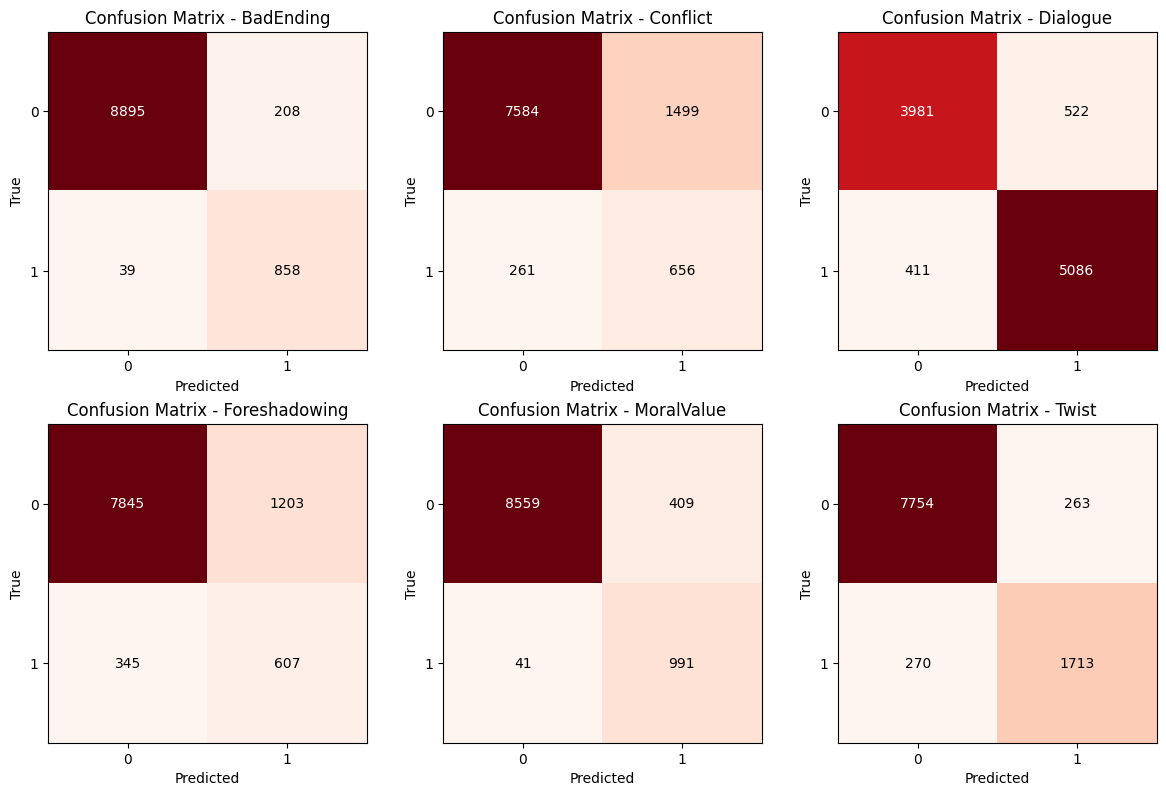

In [54]:
# Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(12, 8))   # 6 labels → 2 rows x 3 columns
axes = axes.flatten()

for i, tag in enumerate(TAGS):
    cm = confusion_matrix(true_tags_B[:, i], pred_tags_B[:, i])
    ax = axes[i]
    im = ax.imshow(cm, cmap='Reds')

    ax.set_title(f"Confusion Matrix - {tag}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])

    for r in range(2):
        for c in range(2):
            ax.text(c, r, cm[r, c], ha="center", va="center", color="white" if cm[r, c] > 0.5 * cm.max() else "black")
    plt.savefig(f"model_B_cm_{tag}.png")


plt.tight_layout()
plt.show()